## Step 1: Project Setup & Context (EN)
Goal: Segment mall customers using Annual Income and Spending Score to design targeted campaigns.

## Adım 1: Proje Kurulumu ve Bağlam (TR)
Amaç: Yıllık Gelir ve Harcama Skoru ile AVM müşterilerini segmente edip hedefli kampanyalar tasarlamak.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Step 2: Load Data & Inspect (EN)
We load the dataset and focus on Annual Income (k$) and Spending Score (1-100).

## Adım 2: Veriyi Yükle ve İncele (TR)
Veriyi yüklüyoruz; Yıllık Gelir (k$) ve Harcama Skoru (1-100) odaklı çalışacağız.

In [2]:
# Load dataset (update path if needed)
df = pd.read_csv("/kaggle/input/abdullah/Mall_Customers.csv")

# Quick look at the data
print("Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nInfo:\n")
print(df.info())
print("\nMissing values:\n", df.isnull().sum())

Shape: (200, 5)

First 5 rows:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Missing va

## Step 3: EDA – Distributions & Scatter (EN)
Check distributions and the relationship between Income and Spending Score.

## Adım 3: Keşifsel Analiz – Dağılımlar ve Saçılım (TR)
Gelir ve Harcama Skoru dağılımlarını ve aralarındaki ilişkiyi inceleyelim.

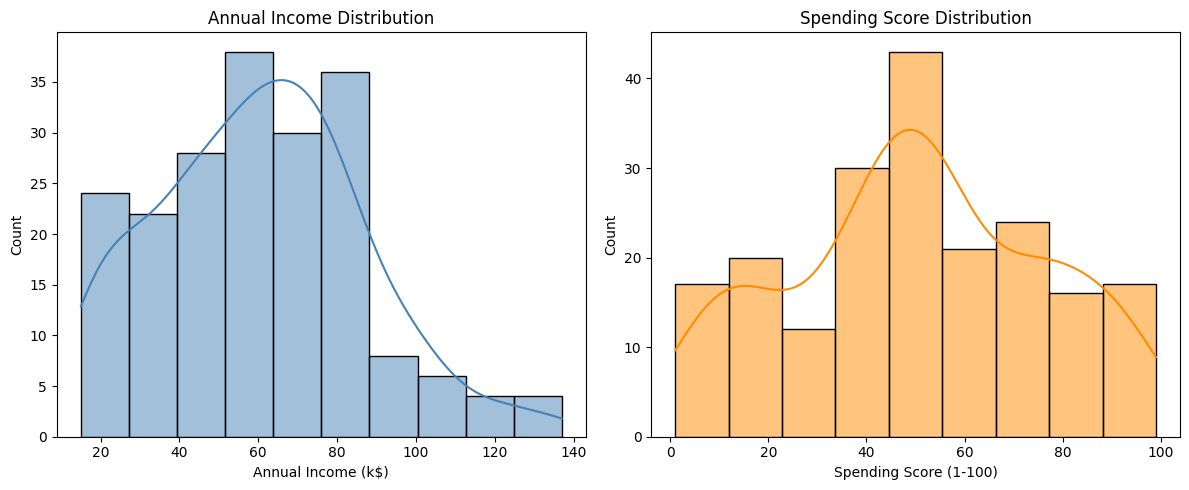

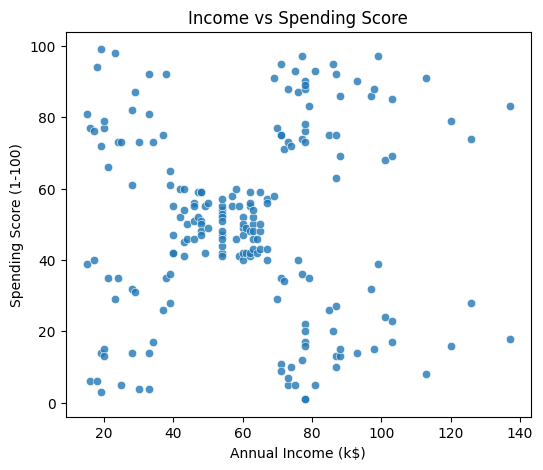

In [3]:
# Distribution plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df["Annual Income (k$)"], kde=True, color="steelblue")
plt.title("Annual Income Distribution")

plt.subplot(1,2,2)
sns.histplot(df["Spending Score (1-100)"], kde=True, color="darkorange")
plt.title("Spending Score Distribution")

plt.tight_layout()
plt.show()

# Scatter plot: Income vs Spending Score
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df["Annual Income (k$)"],
    y=df["Spending Score (1-100)"],
    alpha=0.8
)
plt.title("Income vs Spending Score")
plt.show()

## Step 4: Preprocessing – Select & Scale (EN)
Select the two features and scale them for KMeans stability.

## Adım 4: Ön İşleme – Özellik Seçimi ve Ölçekleme (TR)
İki özelliği seçip KMeans için ölçekliyoruz.

In [4]:
# Select features
features = df[["Annual Income (k$)", "Spending Score (1-100)"]].copy()

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Preview scaled data
X[:5]

array([[-1.73899919, -0.43480148],
       [-1.73899919,  1.19570407],
       [-1.70082976, -1.71591298],
       [-1.70082976,  1.04041783],
       [-1.66266033, -0.39597992]])

## Step 5: Elbow Method – Choose k (EN)
Compute inertia for k=2..10 to find the elbow point.

## Adım 5: Dirsek Yöntemi – k seçimi (TR)
k=2..10 için inertia hesaplayıp dirsek noktasını buluyoruz.

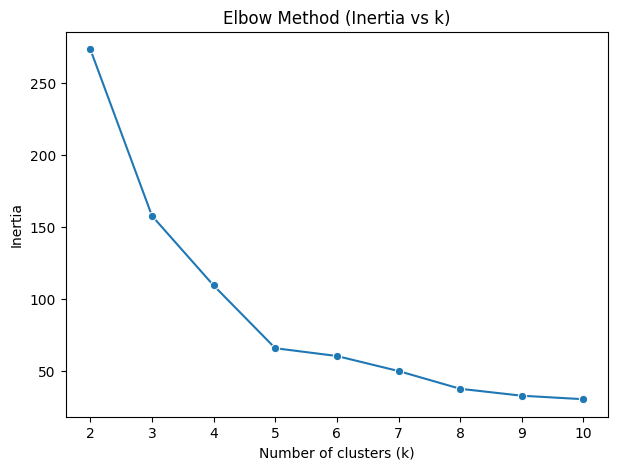

In [5]:
inertias = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
sns.lineplot(x=list(ks), y=inertias, marker="o")
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

## Step 6: Silhouette Score – Validate k (EN)
Evaluate cluster separation quality for k candidates using silhouette score.

## Adım 6: Silhouette Skoru – k doğrulama (TR)
k adayları için küme ayrışma kalitesini silhouette skoru ile değerlendiriyoruz.

In [6]:
sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    sil_scores[k] = silhouette_score(X, labels)

print("Silhouette scores by k:\n", sil_scores)

# Find best k
best_k = max(sil_scores, key=sil_scores.get)
print("\nBest k based on silhouette score:", best_k, "with score:", sil_scores[best_k])

Silhouette scores by k:
 {2: np.float64(0.3973270007887498), 3: np.float64(0.46658474419000145), 4: np.float64(0.49434988482196784), 5: np.float64(0.5546571631111091), 6: np.float64(0.5138257534676561), 7: np.float64(0.50200146805547), 8: np.float64(0.4550112502601921), 9: np.float64(0.4566624374485964), 10: np.float64(0.44475993501732874)}

Best k based on silhouette score: 5 with score: 0.5546571631111091


## Step 7: Fit Final KMeans & Visualize (EN)
Train KMeans with best_k and visualize clusters in original feature space.

## Adım 7: Nihai KMeans ve Görselleştirme (TR)
best_k ile KMeans eğitip kümeleri orijinal özellik uzayında görselleştiriyoruz.

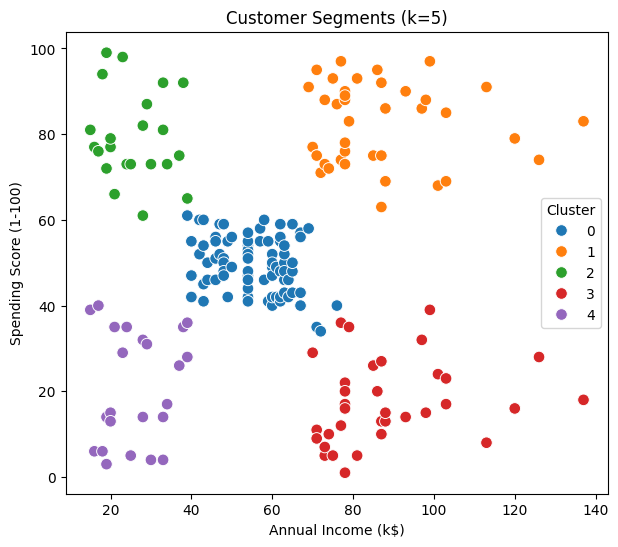

In [7]:
# Final KMeans with best_k
k_final = best_k  # silhouette score'dan gelen en iyi k
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Add cluster labels to dataframe
df["Cluster"] = labels

# Visualization
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=df["Annual Income (k$)"],
    y=df["Spending Score (1-100)"],
    hue=df["Cluster"],
    palette="tab10",
    s=70
)
plt.title(f"Customer Segments (k={k_final})")
plt.legend(title="Cluster")
plt.show()

## Step 8: Segment Profiles & Business Actions (EN)
Profile clusters using mean Income/Spending; design targeted campaigns.

- **High Income, Low Spending:** “Premium but disengaged” → concierge service, loyalty perks.
- **Mid Income, High Spending:** “Value seekers” → bundle deals, seasonal promos.
- **Low Income, Low Spending:** “Budget cautious” → discounts, essential-focused messaging.
- **High Income, High Spending:** “VIPs” → exclusive events, early access.

## Adım 8: Segment Profilleri ve İş Aksiyonları (TR)
Kümeleri ortalama Gelir/Harcama ile profille; hedefli kampanyalar tasarla.

- **Yüksek Gelir, Düşük Harcama:** “Premium ama düşük etkileşim” → concierge, sadakat ayrıcalıkları.
- **Orta Gelir, Yüksek Harcama:** “Değer arayanlar” → paket kampanyalar, sezonluk promosyonlar.
- **Düşük Gelir, Düşük Harcama:** “Bütçe hassas” → indirimler, temel ürün odaklı mesajlar.
- **Yüksek Gelir, Yüksek Harcama:** “VIP” → özel etkinlikler, erken erişim.

In [8]:
# Cluster summary
cluster_summary = df.groupby("Cluster")[["Annual Income (k$)", "Spending Score (1-100)"]].mean().round(1)
cluster_counts = df["Cluster"].value_counts().sort_index()

summary = cluster_summary.copy()
summary["Count"] = cluster_counts.values
summary

,Annual Income (k$),Spending Score (1-100),Count
Cluster,,,
0,55.3,49.5,81
1,86.5,82.1,39
2,25.7,79.4,22
3,88.2,17.1,35
4,26.3,20.9,23


## Step 9: Save Outputs (EN)
Export labeled dataset and cluster summary for stakeholders.

## Adım 9: Çıktıları Kaydet (TR)
Etiketli veri setini ve küme özetini paydaşlar için dışa aktar.

In [9]:
# Save segmented dataset
df.to_csv("mall_customers_segmented.csv", index=False)

# Save cluster summary
summary.to_csv("cluster_summary.csv")

## 🏁 Final Summary

### EN
We successfully segmented mall customers using Annual Income and Spending Score.  
By applying KMeans clustering, we identified distinct customer groups:

- **High Income, Low Spending** → Premium but disengaged customers  
- **Mid Income, High Spending** → Value seekers  
- **Low Income, Low Spending** → Budget cautious  
- **High Income, High Spending** → VIPs  

This segmentation enables mall management to design **targeted marketing campaigns**, optimize budget allocation, and improve customer satisfaction.

### TR
Yıllık Gelir ve Harcama Skoru kullanarak AVM müşterilerini başarıyla segmente ettik.  
KMeans kümeleme ile farklı müşteri grupları ortaya çıktı:

- **Yüksek Gelir, Düşük Harcama** → Premium ama düşük etkileşimli müşteriler  
- **Orta Gelir, Yüksek Harcama** → Değer arayanlar  
- **Düşük Gelir, Düşük Harcama** → Bütçe hassas müşteriler  
- **Yüksek Gelir, Yüksek Harcama** → VIP müşteriler  

Bu segmentasyon sayesinde AVM yönetimi **hedefli kampanyalar** tasarlayabilir, pazarlama bütçesini daha verimli kullanabilir ve müşteri memnuniyetini artırabilir.